In [561]:
import sys, os
sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt

from simulation_new.lensing_sim import LensingSim
from simulation_new.units import *
from astropy.cosmology import Planck15


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [562]:
from simulation_new.subhalos import SubhaloPopulation
from simulation_new.profiles import MassProfileNFW

In [589]:
def Msv(sigma_v):
    """ https://arxiv.org/pdf/1804.04492.pdf
    """
    a = 0.09
    b = 3.48

    l10m = a + b * np.log10(sigma_v / (100*Kmps))
    sigma_l10m = 0.13
    l10m = np.random.normal(l10m, sigma_l10m)
    return (10**l10m)*1e12*M_s

def total_flux_adu(mag, mag_zp):
    """
    Returns total flux of the integrated profile, in ADU relative to mag_zp
    """
    return 10**(-0.4 * (mag - mag_zp))

In [591]:
M_hst = Msv(250*Kmps)
c_hst = MassProfileNFW.c_200_SCP(M_hst)
m_min = 1e7*M_s

z_s = 1.5
z_l = 0.5

D_s = Planck15.angular_diameter_distance(z=z_s).value * Mpc
D_l = Planck15.angular_diameter_distance(z=z_l).value * Mpc

r_s, rho_s = MassProfileNFW.get_r_s_rho_s_NFW(M_hst, c_hst)

ps = PopulationSim(N_calib=150, M_hst=M_hst, c_hst=c_hst, m_min=m_min, theta_s=r_s/D_l)
ps.n_sub_roi

511

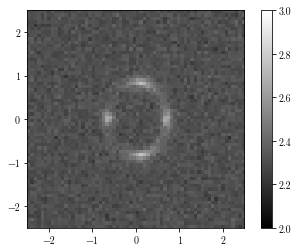

In [602]:
m_sub = ps.m_sample

coordinate_limit = 2.5
exposure = 1610
f_iso = total_flux_adu(22.2, 25.5) 
S_tot = total_flux_adu(25.5, 25.5)

hst_param_dict = {
            "profile": "SIE",
            "theta_x_0": 0.0,
            "theta_y_0": 0.0,
            "theta_E": 1,
            "q": 0.5,
}

lens_list = [hst_param_dict]

for m in m_sub:
    c = MassProfileNFW.c_200_SCP(m)
    r_s, rho_s = MassProfileNFW.get_r_s_rho_s_NFW(m, c)
    sub_param_dict = {
                "profile": "NFW",
                "theta_x_0": np.random.uniform(-2,2),
                "theta_y_0": np.random.uniform(-2,2),
                "M_200": m,
                "r_s": r_s,
                "rho_s": rho_s
    }

    lens_list.append(sub_param_dict)


observation_dict = {
            "n_x": 64,
            "n_y": 64,
            "theta_x_lims": (-coordinate_limit, coordinate_limit),
            "theta_y_lims": (-coordinate_limit, coordinate_limit),
            "exposure": exposure,
            "f_iso": f_iso,
        }

src_param_dict = {
            "profile": "Sersic",
            "theta_x_0": .01,
            "theta_y_0": .01,
            "S_tot": S_tot,
            "theta_e": 0.1,
            "n_srsc": 1,
        }

global_dict = {"z_s": z_s, "z_l": z_l}

lsi = LensingSim(lens_list, 
                 [src_param_dict], 
                 global_dict, 
                 observation_dict)

image = np.random.poisson(lsi.lensed_image())

v_min = 2
v_max = 3.

plt.imshow(np.log10(image),
        vmin=v_min,
        vmax=v_max,
        cmap='gist_gray',
        extent=(-coordinate_limit, coordinate_limit,-coordinate_limit, coordinate_limit),
        origin="lower"
)
plt.colorbar()